In [43]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy import stats
from scipy.stats import binned_statistic
from scipy.linalg import block_diag,eigh
plt.rcParams['font.family']='stixgeneral'
plt.rcParams.update({'font.size':16})
from astropy.io import fits
import ebf
import pdb
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)
from astropy.coordinates import Galactic,match_coordinates_3d
from astropy import units as u1
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from scipy.optimize import curve_fit


In [96]:
datatest = np.loadtxt('halo05_scale6_veldiff_04.txt')

In [97]:
datatest[:,0]

array([-631.17796177, -619.17029382, -607.16262587, -595.15495792,
       -583.14728998, -571.13962203, -559.13195408, -547.12428613,
       -535.11661818, -523.10895023, -511.10128228, -499.09361433,
       -487.08594638, -475.07827843, -463.07061048, -451.06294253,
       -439.05527458, -427.04760663, -415.03993868, -403.03227073,
       -391.02460278, -379.01693483, -367.00926688, -355.00159893,
       -342.99393098, -330.98626303, -318.97859508, -306.97092714,
       -294.96325919, -282.95559124, -270.94792329, -258.94025534,
       -246.93258739, -234.92491944, -222.91725149, -210.90958354,
       -198.90191559, -186.89424764, -174.88657969, -162.87891174,
       -150.87124379, -138.86357584, -126.85590789, -114.84823994,
       -102.84057199,  -90.83290404,  -78.82523609,  -66.81756814,
        -54.80990019,  -42.80223224,  -30.79456429,  -18.78689635,
         -6.7792284 ,    5.22843955,   17.2361075 ,   29.24377545,
         41.2514434 ,   53.25911135,   65.2667793 ,   77.27444

In [98]:
def pdf(data, mean: float, variance: float):
  # A normal continuous random variable.
  s1 = 1/(np.sqrt(2*np.pi*variance))
  s2 = np.exp(-(np.square(data - mean)/(2*variance)))
  return s1 * s2

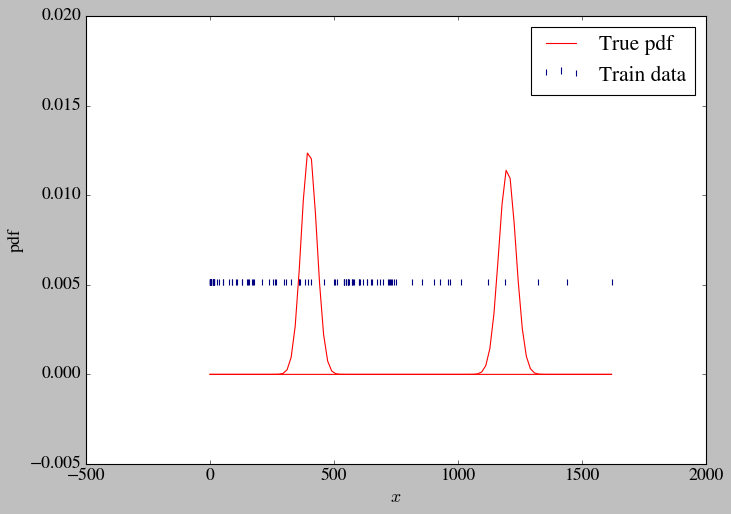

In [28]:
# visualize the training data
X= datatest[:,1]
bins = np.linspace(np.min(X),np.max(X),100)
mu1= 1200
mu2=400
sigma1= 1200
sigma2= 1000

plt.figure(figsize=(10,7))
plt.xlabel("$x$")
plt.ylabel("pdf")
plt.scatter(datatest[:,1], [0.005]*len(datatest[:,1]), color='navy', s=30, marker=2, label="Train data")

plt.plot(bins, pdf(bins, mu1, sigma1), color='red', label="True pdf")
plt.plot(bins, pdf(bins, mu2, sigma2), color='red')
#plt.plot(bins, pdf(bins, mu3, sigma3), color='red')

plt.legend()
plt.plot()
plt.show()

In [29]:
# define the number of clusters to be learned
k = 2
weights = np.ones((k)) / k
means = np.random.choice(X, k)
variances = np.random.random_sample(size=k)
print(means, variances)

[307. 301.] [0.1875968  0.58252408]


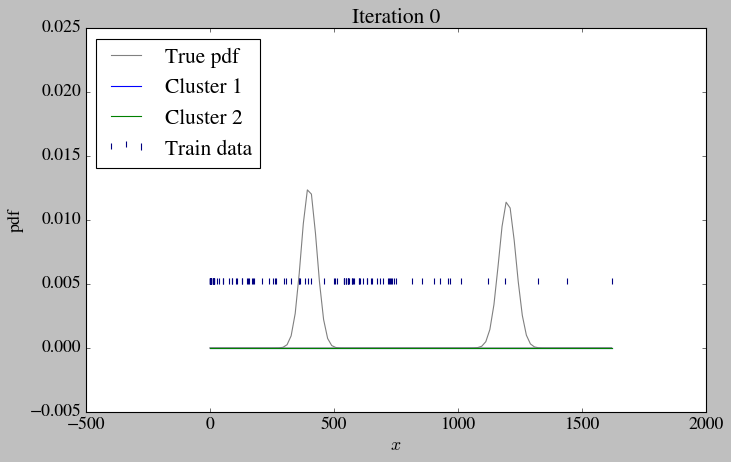

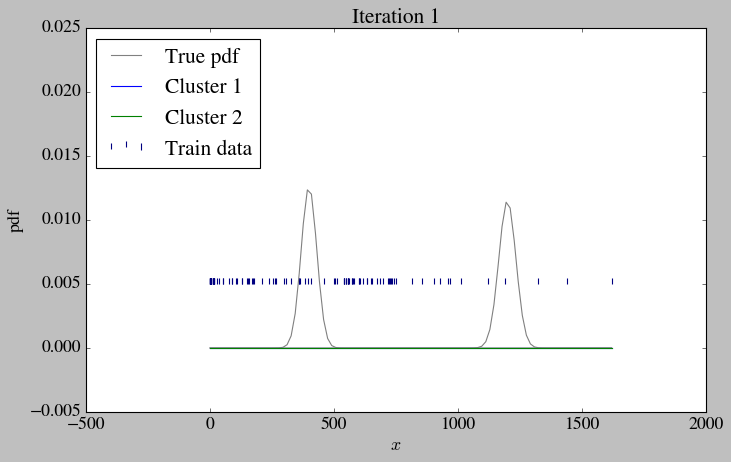

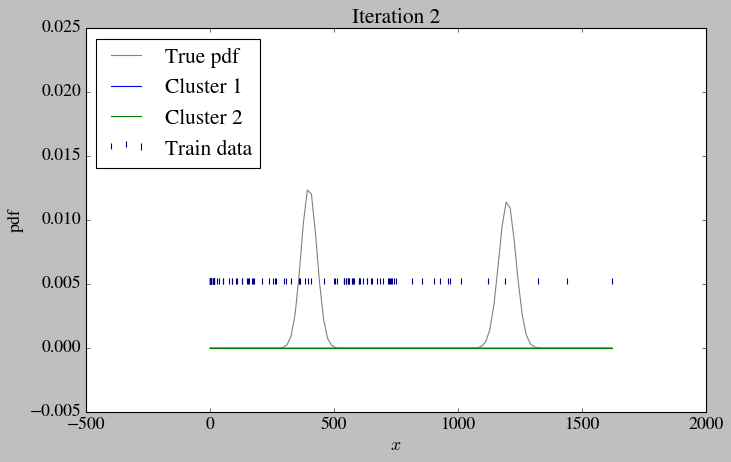

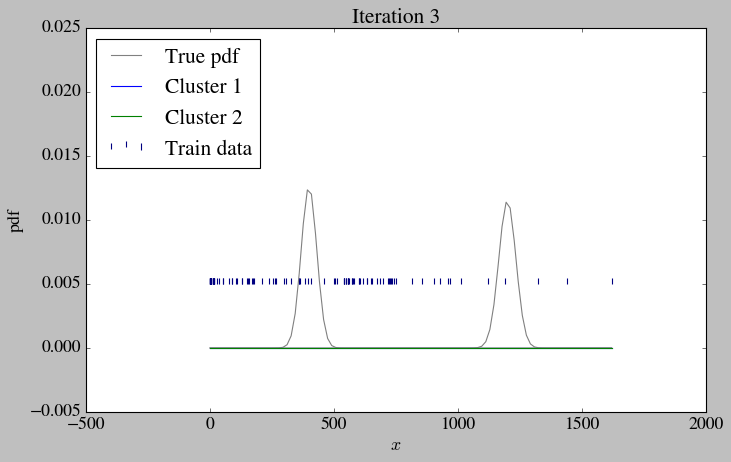

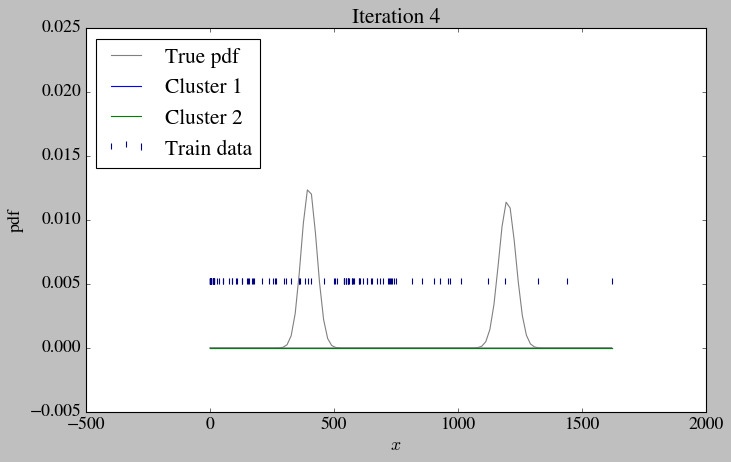

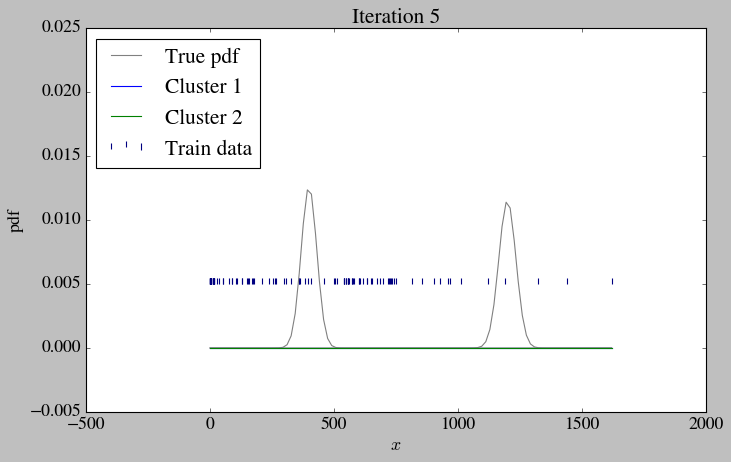

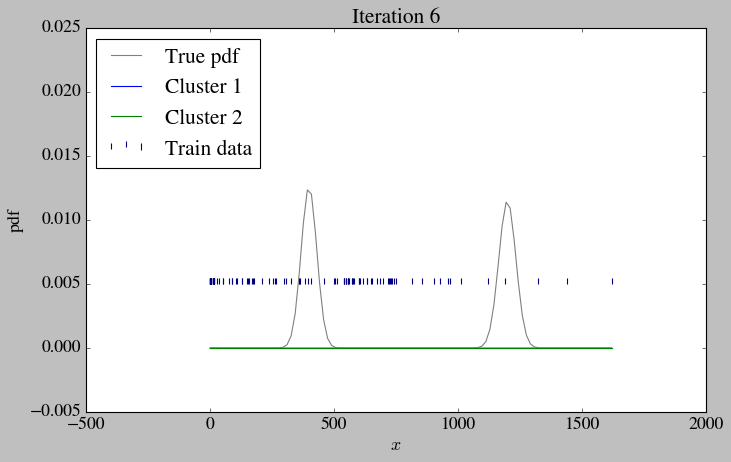

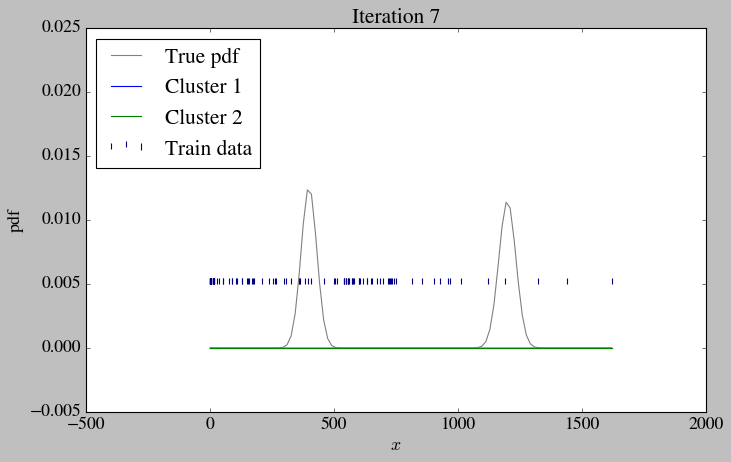

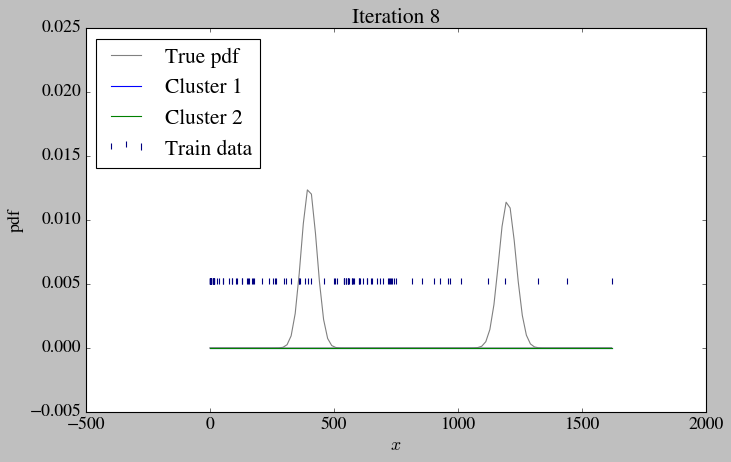

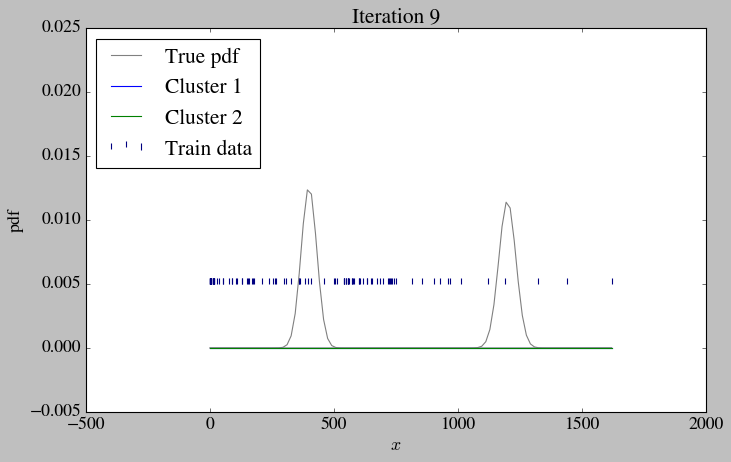

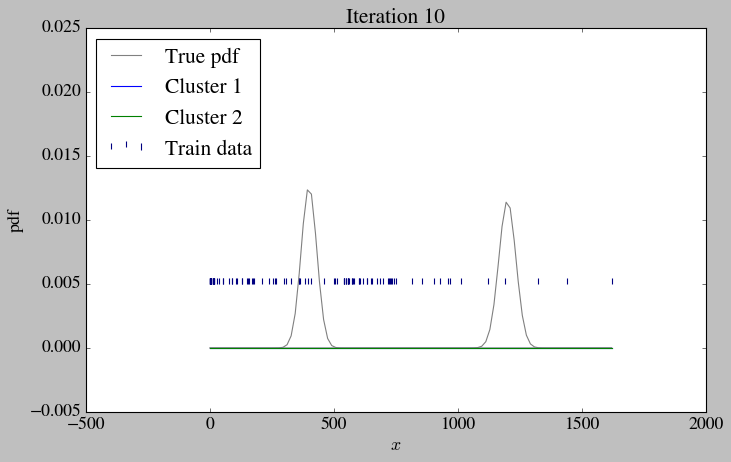

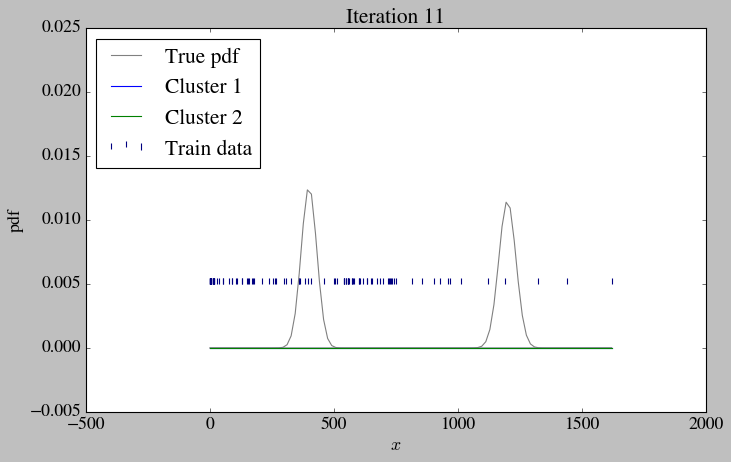

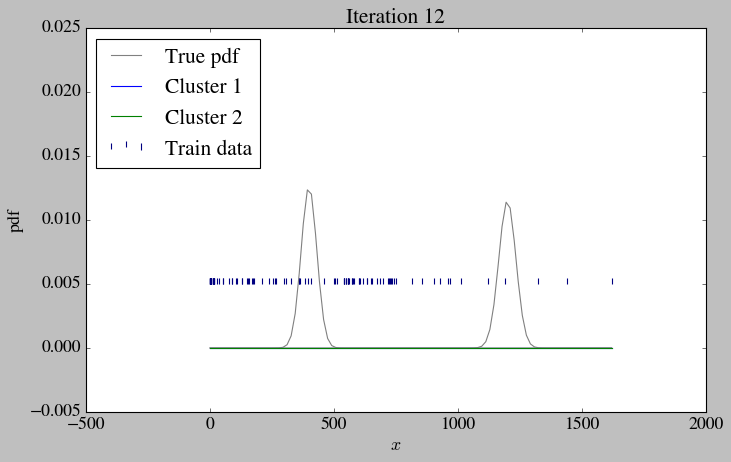

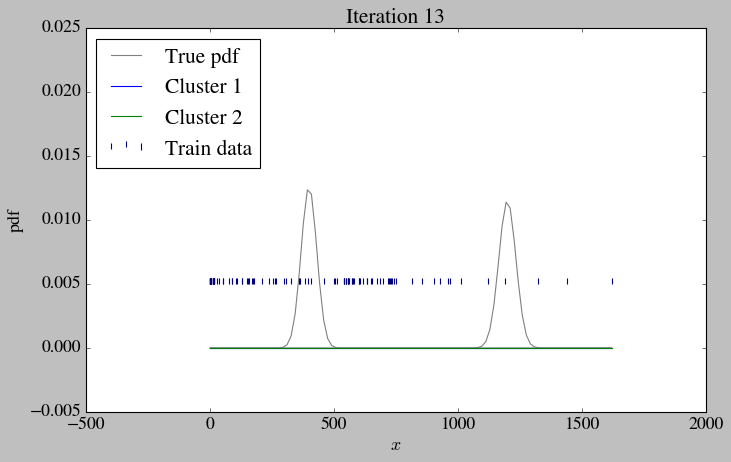

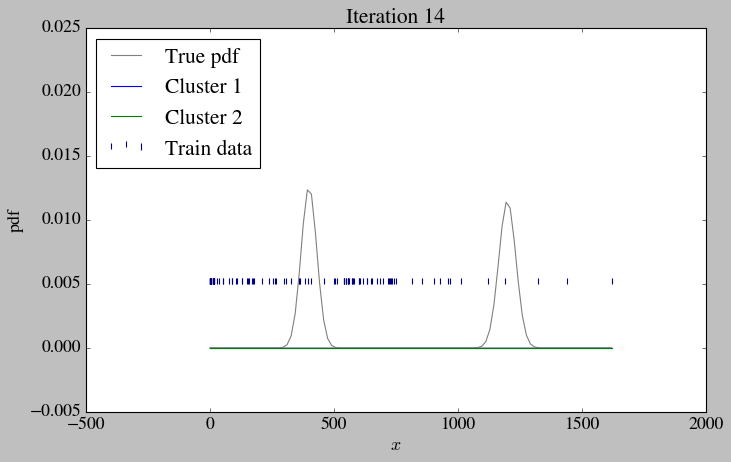

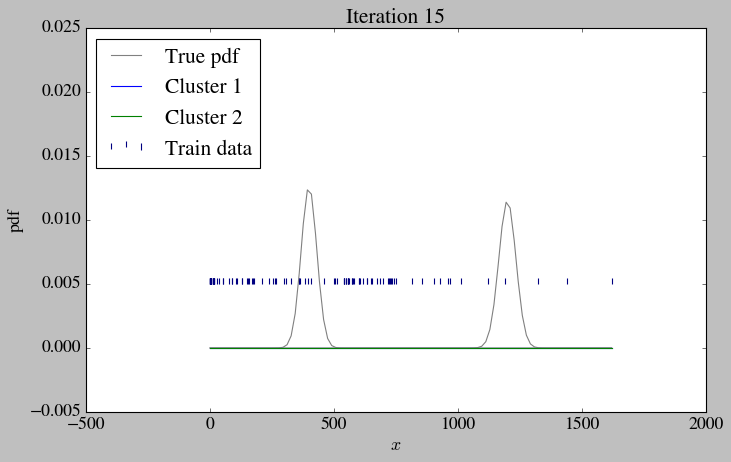

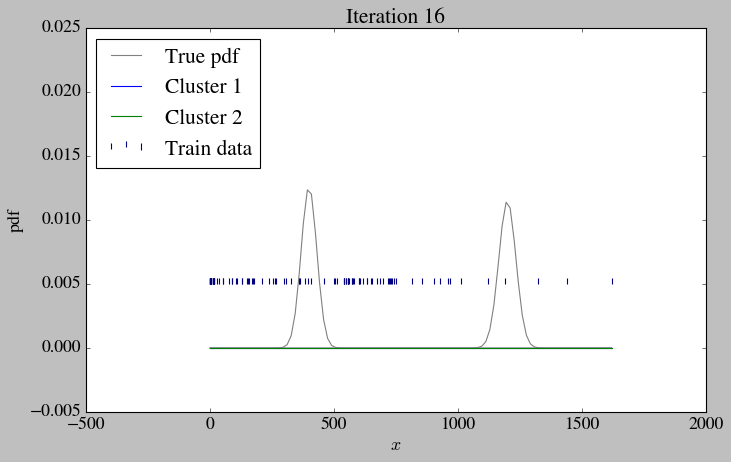

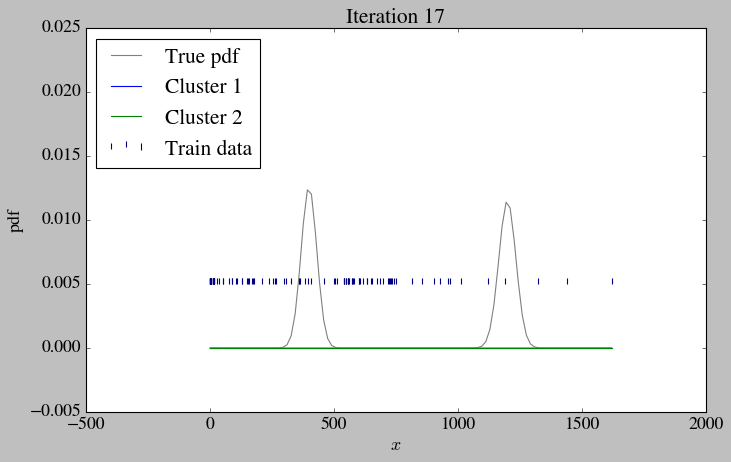

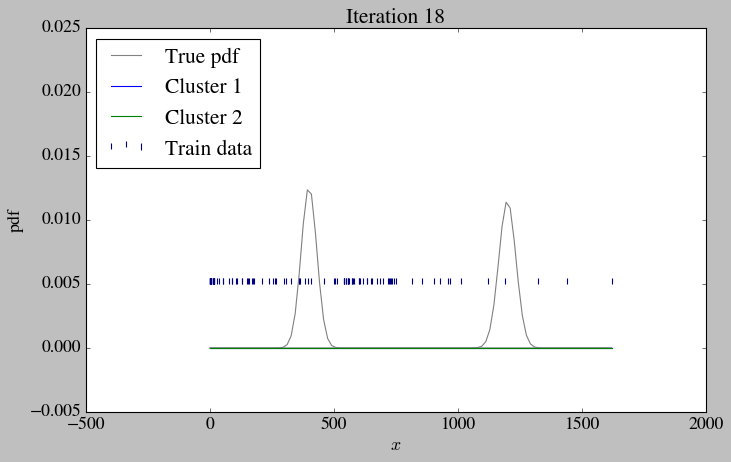

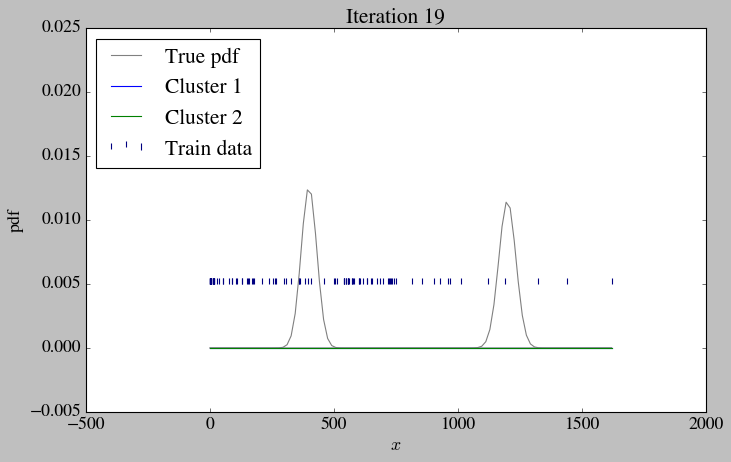

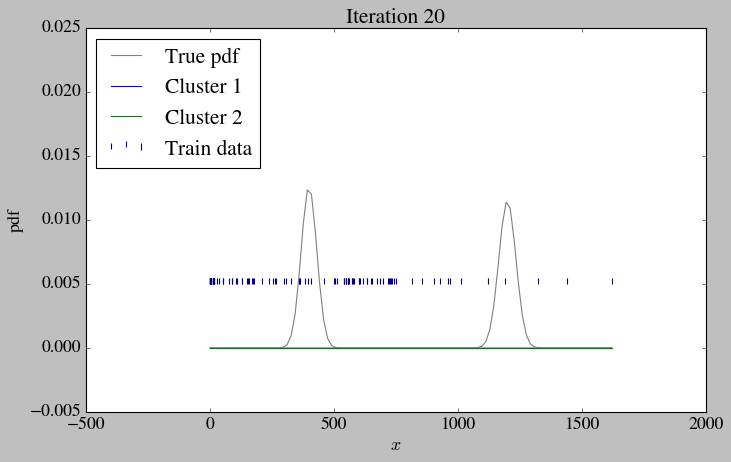

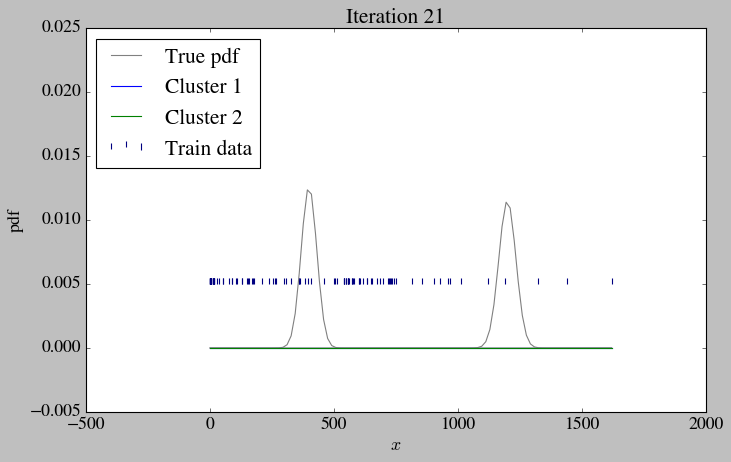

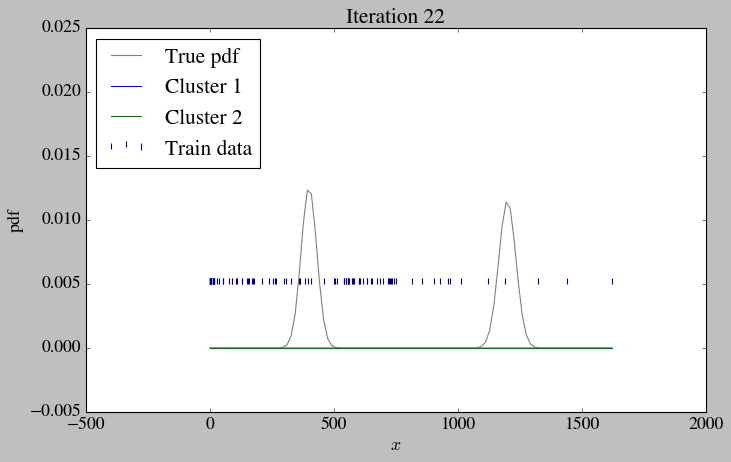

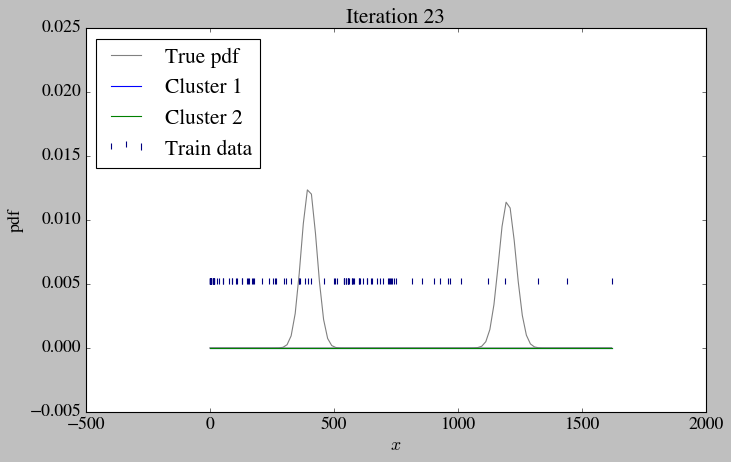

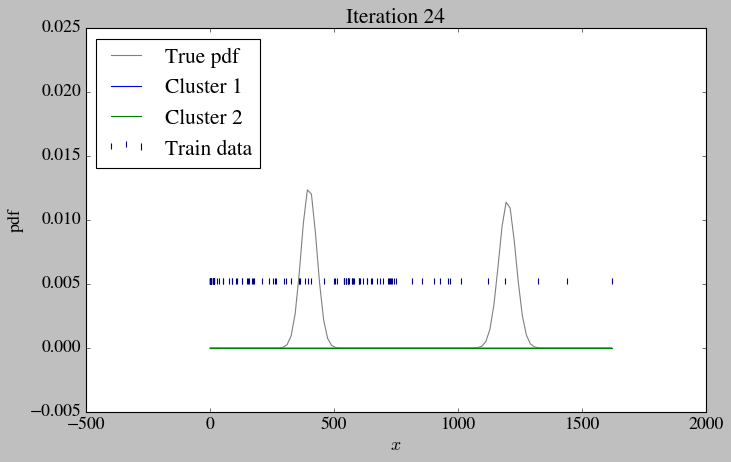

In [30]:
eps=1e-8
for step in range(25):
  
  if step % 1 == 0:
    plt.figure(figsize=(10,6))
    axes = plt.gca()
    plt.xlabel("$x$")
    plt.ylabel("pdf")
    plt.title("Iteration {}".format(step))
    plt.scatter(X, [0.005] * len(X), color='navy', s=30, marker=2, label="Train data")

    plt.plot(bins, pdf(bins, mu1, sigma1), color='grey', label="True pdf")
    plt.plot(bins, pdf(bins, mu2, sigma2), color='grey')
    #plt.plot(bins, pdf(bins, mu3, sigma3), color='grey')

    plt.plot(bins, pdf(bins, means[0], variances[0]), color='blue', label="Cluster 1")
    plt.plot(bins, pdf(bins, means[1], variances[1]), color='green', label="Cluster 2")
    #plt.plot(bins, pdf(bins, means[2], variances[2]), color='magenta', label="Cluster 3")
    
    plt.legend(loc='upper left')
    
    plt.savefig("img_{0:02d}".format(step), bbox_inches='tight')
    plt.show()
  
  # calculate the maximum likelihood of each observation xi
  likelihood = []
  

  # Expectation step
  for j in range(k):
    likelihood.append(pdf(X, means[j], np.sqrt(variances[j])))
  likelihood = np.array(likelihood)
    
  b = []
  # Maximization step 
  for j in range(k):
    # use the current values for the parameters to evaluate the posterior
    # probabilities of the data to have been generanted by each gaussian    
    b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))
  
    # updage mean and variance
    means[j] = np.sum(b[j] * X) / (np.sum(b[j]+eps))
    variances[j] = np.sum(b[j] * np.square(X - means[j])) / (np.sum(b[j]+eps))
    
    # update the weights
    weights[j] = np.mean(b[j])

In [56]:
ee = [1,2,34,5,6,6]
ee[:3]

[1, 2, 34]

# Fitting multiple gaussian to the data

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd


#--------get data--------------------

data = datatest
#data=data.as_matrix()

def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset

def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0)  + 
        offset)
def one_gaussian(x,h1,c1,w1,offset):
    return (gaussian(x, h1, c1, w1, offset))


    
def fitting_result(x,y,h1,c1, w1, h2, c2, w2,offset):
   

    guess6= [h1,c1, w1, h2, c2, w2,offset]

    optim1, success1 = curve_fit(two_gaussians, x, y,p0=[guess6[:]])
    optim2, success2 = curve_fit(one_gaussian, x, y,p0=[h1,c1, w1,offset])
    chisq1 = np.sum((two_gaussians(x, *optim1) - y)**2/two_gaussians(x, *optim1))
    chisq2 = np.sum((one_gaussian(x, *optim2) - y)**2/one_gaussian(x, *optim2))
    print (chisq1,chisq
    if chisq1 < chisq2:
        return optim1, success1
    else:
        return optim2, success2



[ 3.12246398e+03 -8.33245010e+00  2.44503996e+01  6.98328407e+02
 -8.36980832e+00  2.00262675e+02 -5.23612689e-01] [[ 6.71938426e+02 -6.45125088e-05 -1.84634266e+00 -9.77586482e+01
  -9.37757720e-03  3.02480403e+01 -2.14519502e+01]
 [-6.45125088e-05  4.83333900e-02 -8.06063157e-07  1.05505250e-04
  -7.29931923e-02 -5.20540228e-05  2.64226574e-05]
 [-1.84634266e+00 -8.06063157e-07  6.38853066e-02 -1.35601519e+00
  -1.22543595e-04  3.73251122e-01 -2.51896127e-01]
 [-9.77586482e+01  1.05505250e-04 -1.35601519e+00  1.54394164e+02
   2.87489020e-03 -1.70883009e+01 -2.20357486e+01]
 [-9.37757720e-03 -7.29931923e-02 -1.22543595e-04  2.87489020e-03
   7.91479830e+00 -2.81183794e-03  4.41955606e-03]
 [ 3.02480403e+01 -5.20540228e-05  3.73251122e-01 -1.70883009e+01
  -2.81183794e-03  2.03001079e+01 -2.23110197e+01]
 [-2.14519502e+01  2.64226574e-05 -2.51896127e-01 -2.20357486e+01
   4.41955606e-03 -2.23110197e+01  4.95497760e+01]]
255.25949884780843 4108.709817637198


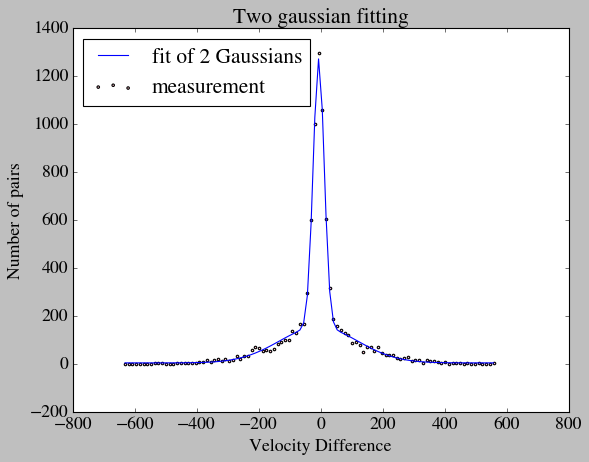

In [100]:
print (optim6,success)
plt.scatter(data[:,0], data[:,1], c='pink', label='measurement', marker='.', edgecolors=None)
plt.plot(data[:,0], two_gaussians(data[:,0], *fitting_result(data[:,0],data[:,1],2000,0,100,1000
, 0, 2.00262675e+02 ,0)[0]),
    c='b', label='fit of 2 Gaussians')
plt.title("Two gaussian fitting")
plt.ylabel("Number of pairs")
plt.xlabel("Velocity Difference")
plt.legend(loc='upper left')
#plt.savefig('result.png')
plt.show()